## Notebook on FineTuning different current state of the art CNN models

What to expect: <br/>
1. Application of Image Folder Dataloader
2. Application of model training, validation and test

Models included in this Notebook:
- InceptionV3
- ResNet50
- ResNet152
- EfficientNetV2-s
- DenseNet121
- VGG16_bn
- MaxViT

### 1. Application of dataloader
Ensure that your dataset is in the following format
```
Image_Folder
|- Train
|  |- Class 1
|  |- Class 2
|
|- Validation
|  |- Class 1
|  |- Class 2
|
|- Test
|  |- Class 1
|  |- Class 2
```

In [2]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
#Parameter Setup
image_size = (299,299)
batch_size = 64

In [4]:
#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

In [5]:
# Create PyTorch datasets for training and validation
train_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Train', 
                    transform=train_transform
                    )
val_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Validation', 
                    transform=eval_transform
                    )
test_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
val_dataloader = torch.utils.data.DataLoader(
                    val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
test_dataloader = torch.utils.data.DataLoader(
                    test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

In [5]:
def class_labels(dataset):
    """
    Create a dictionary of the dataset index to it's true text labels

    Args:
        dataset (Dataset): Torch Dataset 

    Returns:
        dictionary of the class labels in the format of {"tensor index": "labels in string"}
    """

    class_dict = {}
    for idx, label in enumerate(dataset.classes):
        class_dict[idx] = label

    print(f"Class Labels, {class_dict}")
    return class_dict

In [6]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


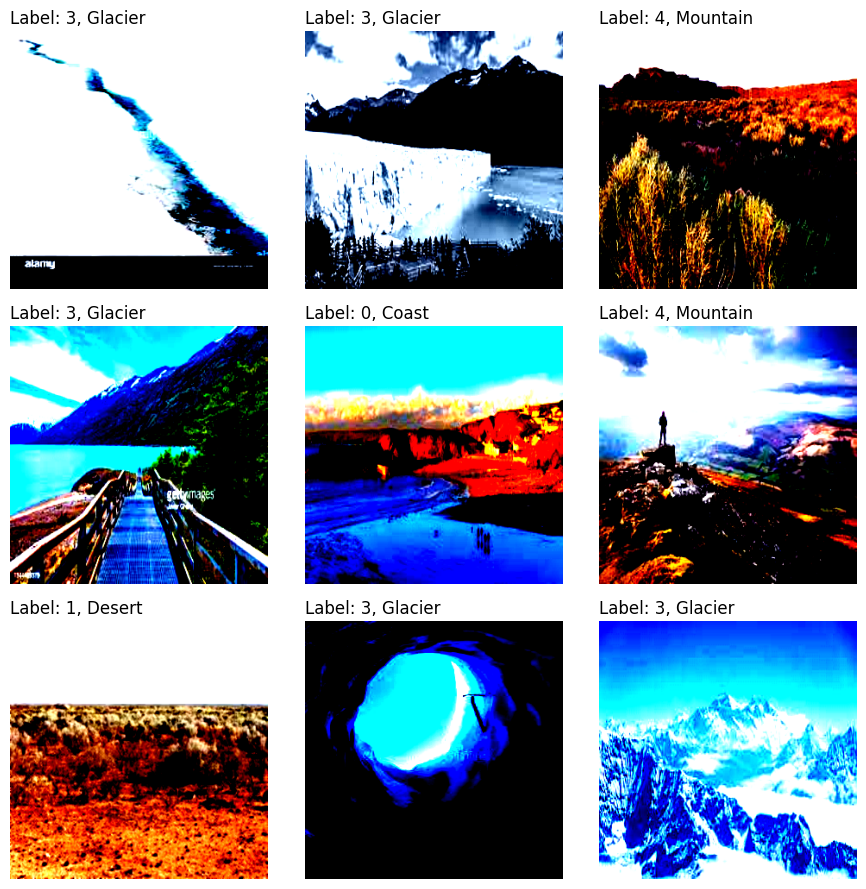

In [7]:
visualise_img(train_dataloader, train_dataset.classes)

### 2. Training and Evaluations Functions

In [8]:
def finetuning_eval(
    model, 
    criterion, 
    val_dataloader, 
    device:str='cuda'):

  """
  Evaluation function for finetuning CNN models

  Args:
    model: CNN model
    criterion: Loss function
    val_dataloader: Validation / Test dataloader
    device (str, optional): 'cpu' or 'cuda', defaults to cuda

  Returns:
      accuracy: float of the accuracy
      avg_val_loss: float of the average val loss
  """

  #set model to eval mode
  model.eval()

  #variables 
  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for image, label in val_dataloader:
        image = image.to(device)
        label = label.to(device)

        outputs = model(image) #predict label 
        loss = criterion(outputs, label) #calculate loss
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item() #check if predicted is the same as the label

  #calculate accuracy and loss
  accuracy = (correct / total) * 100
  avg_val_loss = val_loss / len(val_dataloader)

  return accuracy, avg_val_loss


In [19]:
def finetuning_train(model, 
                  criterion, 
                  optimiser, 
                  train_dataloader, 
                  val_dataloader=None, 
                  num_epochs:int=25, 
                  device:str='cuda', 
                  model_name:str=None):
  
  """
  Training function for CNN models

  Args:
    model: CNN model to be finetuned
    criterion: Loss function
    optimiser: Optimiser function of the model
    train_dataloader: Train Dataset
    val_dataloader (optional): Validation Dataset, use None if no Validation dataset
    num_epochs (int, optional): Number of training epochs, defaults to 25
    device (str, optional): cpu or cuda, defaults to cuda
    model_name (str, optional): Model Name for saving model, None if no saving to be done. Defaults to None

  Returns:
      train_loss: list of the average train loss per epoch
      val_loss: list of the average val loss per epoch
  """

  #initialising results container
  train_loss = []
  val_loss = []

  for epoch in range(num_epochs):

    #model in train mode
    model.train()
    training_loss = 0.0

    #training model
    for image, label in tqdm(train_dataloader):
      image = image.to(device)
      label = label.to(device)

      optimiser.zero_grad()
      outputs = model(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimiser.step()
      training_loss += loss.item()

    epoch_loss = training_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

    #train if there is a validation dataset
    if val_dataloader != None:
      accuracy, avg_val_loss = finetuning_eval(model, criterion, val_dataloader, device)
      print(f"Validation loss: {avg_val_loss}, Validation Accuracy: {accuracy:.2f}")
      val_loss.append(avg_val_loss)

    train_loss.append(epoch_loss)

    #saving best model based on lowest validation loss (no validation dataset = no best model saving)
    #only runs if there is a model name to save the model on
    if len(val_loss) > 1 and val_loss[-1] < min(val_loss[:-1]) and model_name!=None:
      torch.save(model, f'../models/cnn/{model_name}_best.pt')
      print("Best model saved")

  #saving the last model if there is a model name
  if model_name != None:
    torch.save(model, f'../models/cnn/{model_name}_{num_epochs}.pt')
  
  return train_loss, val_loss


### 3. Base Finetuning Model Class

In [52]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### 4. Finetuning and Evaluation of models

In [56]:
#Clearing GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

11952

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### InceptionV3

##### Training

In [58]:
model = PreTrainedCNNModels('InceptionV3', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [59]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'incept_10')

100%|██████████| 157/157 [00:21<00:00,  7.41it/s]


Epoch 1 completed, training loss: 1.3022496426940724
Validation loss: 0.9558627133568128, Validation Accuracy: 73.53


100%|██████████| 157/157 [00:20<00:00,  7.62it/s]


Epoch 2 completed, training loss: 0.9318433643146685
Validation loss: 0.754824216167132, Validation Accuracy: 76.20
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


Epoch 3 completed, training loss: 0.8156717571483296
Validation loss: 0.6939257855216662, Validation Accuracy: 77.53
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.64it/s]


Epoch 4 completed, training loss: 0.7507956867005415
Validation loss: 0.649294118086497, Validation Accuracy: 77.20
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 5 completed, training loss: 0.7139818898052167
Validation loss: 0.6169751385847727, Validation Accuracy: 78.47
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.63it/s]


Epoch 6 completed, training loss: 0.695091804691181
Validation loss: 0.594037376344204, Validation Accuracy: 79.33
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.36it/s]


Epoch 7 completed, training loss: 0.6622082520822051
Validation loss: 0.5804555863142014, Validation Accuracy: 79.93
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.48it/s]


Epoch 8 completed, training loss: 0.6413609767036074
Validation loss: 0.5686273997028669, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


Epoch 9 completed, training loss: 0.6331562882016419
Validation loss: 0.5622281258304914, Validation Accuracy: 80.40
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch 10 completed, training loss: 0.6164525229080468
Validation loss: 0.5537205040454865, Validation Accuracy: 80.67
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch 11 completed, training loss: 0.6006745035481301
Validation loss: 0.5458044931292534, Validation Accuracy: 81.00
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch 12 completed, training loss: 0.5891432215453712
Validation loss: 0.5509788493315378, Validation Accuracy: 80.33


100%|██████████| 157/157 [00:20<00:00,  7.68it/s]


Epoch 13 completed, training loss: 0.5859680249812497
Validation loss: 0.5323684737086296, Validation Accuracy: 81.07
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.62it/s]


Epoch 14 completed, training loss: 0.5854757718599526
Validation loss: 0.541185682018598, Validation Accuracy: 81.07


100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Epoch 15 completed, training loss: 0.5694874768993657
Validation loss: 0.5261608635385832, Validation Accuracy: 81.53
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.27it/s]


Epoch 16 completed, training loss: 0.5646661216286337
Validation loss: 0.5307692475616932, Validation Accuracy: 81.73


100%|██████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 17 completed, training loss: 0.5508620554854156
Validation loss: 0.5204428546130657, Validation Accuracy: 82.00
Best model saved


100%|██████████| 157/157 [00:23<00:00,  6.62it/s]


Epoch 18 completed, training loss: 0.5478808002866757
Validation loss: 0.5134126779933771, Validation Accuracy: 82.27
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.63it/s]


Epoch 19 completed, training loss: 0.5547615547848356
Validation loss: 0.5138477136691412, Validation Accuracy: 82.07


100%|██████████| 157/157 [00:20<00:00,  7.58it/s]


Epoch 20 completed, training loss: 0.5334400314434319
Validation loss: 0.5094608304401239, Validation Accuracy: 81.93
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.68it/s]


Epoch 21 completed, training loss: 0.5384196489100244
Validation loss: 0.5124423044423262, Validation Accuracy: 82.13


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 22 completed, training loss: 0.5220862735228934
Validation loss: 0.5044683404266834, Validation Accuracy: 82.47
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.49it/s]


Epoch 23 completed, training loss: 0.5203957092610134
Validation loss: 0.5055431493868431, Validation Accuracy: 82.20


100%|██████████| 157/157 [00:20<00:00,  7.71it/s]


Epoch 24 completed, training loss: 0.521695383225277
Validation loss: 0.5191930495202541, Validation Accuracy: 82.20


100%|██████████| 157/157 [00:20<00:00,  7.48it/s]


Epoch 25 completed, training loss: 0.5175500872788156
Validation loss: 0.5122747247417768, Validation Accuracy: 82.07


100%|██████████| 157/157 [00:20<00:00,  7.64it/s]


Epoch 26 completed, training loss: 0.5190601654493125
Validation loss: 0.5006841383874416, Validation Accuracy: 82.67
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.64it/s]


Epoch 27 completed, training loss: 0.5036859394638402
Validation loss: 0.510811143865188, Validation Accuracy: 82.33


100%|██████████| 157/157 [00:20<00:00,  7.52it/s]


Epoch 28 completed, training loss: 0.5066823566415507
Validation loss: 0.5080175958573818, Validation Accuracy: 82.67


100%|██████████| 157/157 [00:20<00:00,  7.66it/s]


Epoch 29 completed, training loss: 0.4990201376046345
Validation loss: 0.4942393420885007, Validation Accuracy: 82.60
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.50it/s]


Epoch 30 completed, training loss: 0.5059849745149065
Validation loss: 0.49917781973878544, Validation Accuracy: 82.27


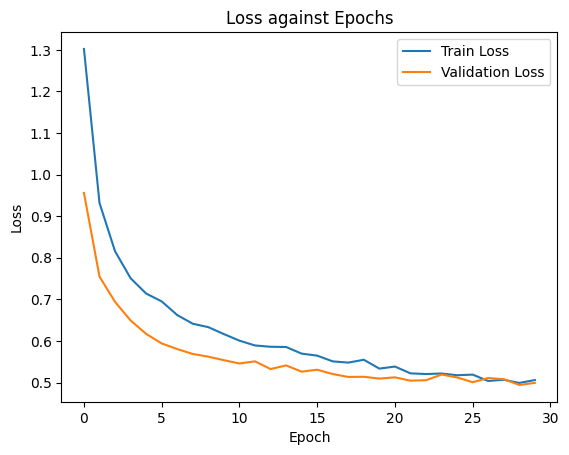

In [60]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [61]:
best_model = torch.load('../models/cnn/incept_10_30.pt')

In [62]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 91.0, test_loss: 0.31900337152183056


#### ResNet50

##### Training

In [63]:
model = PreTrainedCNNModels('Resnet50', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [64]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'resnet50_10')

100%|██████████| 157/157 [00:25<00:00,  6.21it/s]


Epoch 1 completed, training loss: 1.3354945763660844
Validation loss: 1.0760429327686627, Validation Accuracy: 71.07


100%|██████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 2 completed, training loss: 0.9683531439228422
Validation loss: 0.8442641297976176, Validation Accuracy: 74.33
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 3 completed, training loss: 0.8026111391699238
Validation loss: 0.7450595423579216, Validation Accuracy: 75.80
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 4 completed, training loss: 0.7188203160170537
Validation loss: 0.7066129744052887, Validation Accuracy: 76.13
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 5 completed, training loss: 0.6629707471580263
Validation loss: 0.6578159779310226, Validation Accuracy: 77.00
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 6 completed, training loss: 0.6305644067989034
Validation loss: 0.6332684059937795, Validation Accuracy: 77.53
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 7 completed, training loss: 0.6026449324978385
Validation loss: 0.6122509787480036, Validation Accuracy: 78.80
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.30it/s]


Epoch 8 completed, training loss: 0.5797512257934376
Validation loss: 0.6074247335394224, Validation Accuracy: 78.53
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.31it/s]


Epoch 9 completed, training loss: 0.5649356880005757
Validation loss: 0.5971740471820036, Validation Accuracy: 78.27
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.48it/s]


Epoch 10 completed, training loss: 0.5448312599947498
Validation loss: 0.5847541640202204, Validation Accuracy: 78.67
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 11 completed, training loss: 0.5374436410749035
Validation loss: 0.586134402702252, Validation Accuracy: 79.13


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 12 completed, training loss: 0.5217022630059795
Validation loss: 0.5684441762665907, Validation Accuracy: 79.20
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 13 completed, training loss: 0.511675020312048
Validation loss: 0.5636927199860414, Validation Accuracy: 78.80
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 14 completed, training loss: 0.5014180131019301
Validation loss: 0.5728387807806333, Validation Accuracy: 79.80


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 15 completed, training loss: 0.4972193233526436
Validation loss: 0.5504984992245833, Validation Accuracy: 80.07
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.50it/s]


Epoch 16 completed, training loss: 0.49234744754566506
Validation loss: 0.5513184927403927, Validation Accuracy: 79.93


100%|██████████| 157/157 [00:24<00:00,  6.49it/s]


Epoch 17 completed, training loss: 0.47822658442387916
Validation loss: 0.553309245655934, Validation Accuracy: 79.67


100%|██████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 18 completed, training loss: 0.46931640025536725
Validation loss: 0.5479748571912447, Validation Accuracy: 79.93
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 19 completed, training loss: 0.47169419268893586
Validation loss: 0.5511140562593937, Validation Accuracy: 79.80


100%|██████████| 157/157 [00:24<00:00,  6.38it/s]


Epoch 20 completed, training loss: 0.46796096424767925
Validation loss: 0.5380247458815575, Validation Accuracy: 80.13
Best model saved


100%|██████████| 157/157 [00:27<00:00,  5.80it/s]


Epoch 21 completed, training loss: 0.44726466259379294
Validation loss: 0.5425900916258494, Validation Accuracy: 80.13


100%|██████████| 157/157 [00:31<00:00,  5.04it/s]


Epoch 22 completed, training loss: 0.4432066682797329
Validation loss: 0.5337577772637209, Validation Accuracy: 80.40
Best model saved


 66%|██████▌   | 104/157 [00:16<00:08,  6.17it/s]

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/resnet50_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### Resnet152

##### Training

In [ ]:
model = PreTrainedCNNModels('Resnet152', 10, len(train_dataset.classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'resnet152_10')

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/resnet152_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### EfficientNet

##### Training

In [ ]:
model = PreTrainedCNNModels('EfficientNet', 10, len(train_dataset.classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'efficient_10')

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/efficient_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### DenseNet

##### Training

In [ ]:
model = PreTrainedCNNModels('DenseNet', 10, len(train_dataset.classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'dense_10')

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/dense_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### VGG16

##### Training

In [ ]:
model = PreTrainedCNNModels('VGG16', 10, len(train_dataset.classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'vgg_10')

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/vgg_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### MaxVit

##### Training

In [ ]:
model = PreTrainedCNNModels('MaxVit', 10, len(train_dataset.classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'maxvit_10')

In [ ]:
#plotting line graph of training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/maxvit_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

#### Others

In [ ]:
#### Others
model = PreTrainedCNNModels('SqueezeNet', 1, len(train_dataset.classes)).to(device)

## INCEPTIONV3

In [ ]:
#Clearing GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

In [64]:
class InceptionV3(torch.nn.Module):
    def __init__(self, class_dict, num_unfreeze):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.inception.fc = torch.nn.Linear(self.inception.fc.in_features, len(class_dict.keys()))
        self.inception.aux_logits = False

        for param in self.inception.parameters():
          param.requires_grad = False

        
        # for name, param in self.inception.named_parameters():
        #     if name in ['fc.weight', 'fc.bias']:
        #         param.requires_grad = True

        parameters = list(self.inception.parameters())
        for param in parameters[-num_unfreeze:]:
          param.requires_grad = True
        
        # print(list(self.inception.parameters())[-4:])

    def forward(self, images):
        features = self.inception(images)

        return features

### Training Linear Layer

In [106]:
model = InceptionV3(class_dict, 2).to('cuda') #2 for fc weights and bias

In [107]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'incept_1')

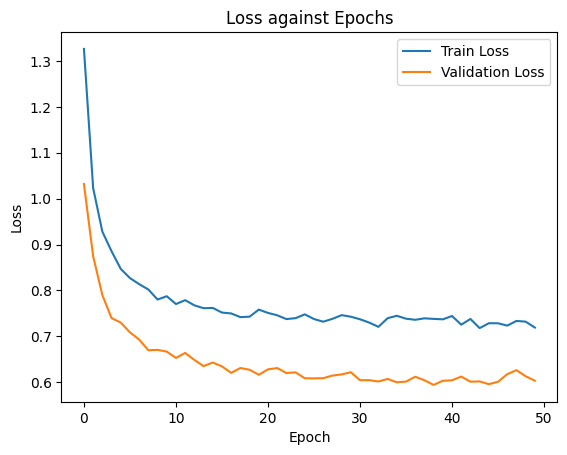

In [110]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Training last 10 layers

In [111]:
model = InceptionV3(class_dict, 10).to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [88]:
model = InceptionV3(class_dict, 10).to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'incept_10')

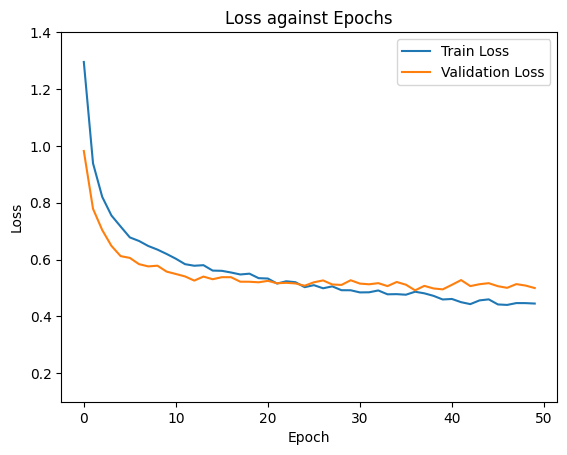

In [90]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')
plt.ylim([0.1, 1.4])

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Evaluation

In [128]:
best_model = torch.load('../models/cnn/resnet50/resnet_20_50.pt')

In [129]:
accuracy, avg_test_loss = eval(best_model,
                             criterion,
                             test_dataloader,
                              'cuda')

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 92.2, test_loss: 0.2575994823127985


## RESNET50

In [11]:
class ResNet50(torch.nn.Module):
    def __init__(self, class_dict, num_unfreeze):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, len(class_dict.keys()))

        for param in self.resnet.parameters():
          param.requires_grad = False

        parameters = list(self.resnet.parameters())
        for param in parameters[-num_unfreeze:]:
          param.requires_grad = True

    def forward(self, images):
        features = self.resnet(images)

        return features

### Training Linear Layer

In [12]:
model = ResNet50(class_dict, 2).to('cuda')

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'resnet_1')

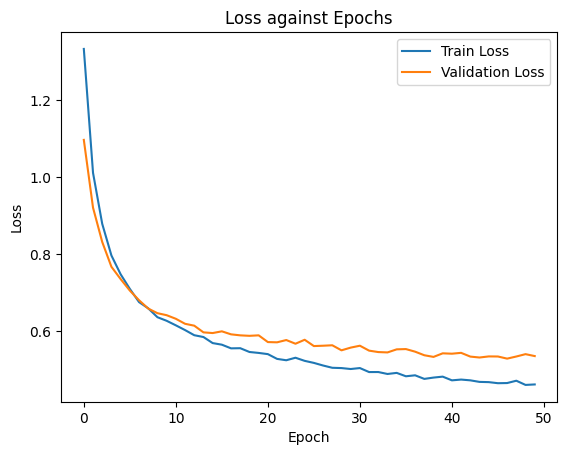

In [15]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Adding legend
plt.legend()
plt.ylim([0.1, 1.4])

# Displaying the plot
plt.show()


#plotting line graph of training loss against validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

#labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

#show legend
plt.legend()
plt.show()



### Training last 15 layers

In [39]:
model = ResNet50(class_dict, 15).to('cuda')

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = train(model,
                             criterion,
                             optimizer,
                             train_dataloader,
                             val_dataloader,
                             50,
                             'cuda',
                             'resnet_20')

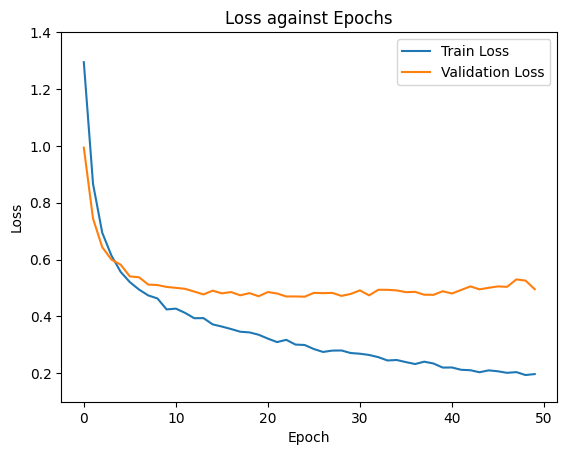

In [53]:
import matplotlib.pyplot as plt

# Plotting the first line graph
plt.plot(train_loss, label='Train Loss')

# Plotting the second line graph
plt.plot(val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss against Epochs')
plt.ylim([0.1, 1.4])

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


In [158]:
best_model = torch.load('../models/cnn/resnet_152_30.pt')

In [159]:
accuracy, avg_test_loss = eval(best_model,
                             criterion,
                             test_dataloader,
                              'cuda')

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 90.0, test_loss: 0.25748731940984726
